#Telecom X - Análisis de Evasión de Clientes
**Autor: **Alexander Jamin Julon Mayta
**Fecha:** 02/08/2025

Resumen: Este análisis tiene como objetivo ayudar al Sr. Juan a decidir cuál de sus cuatro tiendas de la cadena Alura Store debería vender para iniciar un nuevo emprendimiento. A través del estudio de métricas clave como ingresos, volumen de ventas, reseñas de clientes y eficiencia logística, se identifican las fortalezas y debilidades de cada tienda. El análisis se apoya en visualizaciones claras y concluye con una recomendación basada en datos.

#📌 Extracción

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

archivo = 'https://github.com/AlekJulM/TelecomX_Data-science-LATAM/raw/refs/heads/main/TelecomX_Data.json'
datos = pd.read_json(archivo)


#🔧 Transformación

In [65]:
#normalización de columnas con estructuras anidadas
columnas_json = datos.columns[2:]

df_final = pd.concat([
    datos.drop(columns=columnas_json),
    *[
        pd.json_normalize(datos[col])
        for col in columnas_json
    ]
], axis=1)
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [66]:
#Cuando los meses de contrato son 0, el cargo total es un espacio vacio, se remplazara por 0
df_final[df_final['Charges.Total'] == ' '][['tenure','Charges.Total']]
df_final['Charges.Total'] = df_final['Charges.Total'].str.replace(' ', '0')
df_final['Charges.Total'] = df_final['Charges.Total'].astype(np.float64)

In [67]:
#conviertiendo tipo de datos object a int
df_final['Partner'] = df_final['Partner'].replace({'Yes': 1, 'No': 0})
df_final['Partner'] = df_final['Partner'].astype('Int8')
df_final['Dependents'] = df_final['Dependents'].replace({'Yes': 1, 'No': 0})
df_final['Dependents'] = df_final['Dependents'].astype('Int8')
df_final['PhoneService'] = df_final['PhoneService'].replace({'Yes': 1, 'No': 0})
df_final['PhoneService'] = df_final['PhoneService'].astype('Int8')

/tmp/ipython-input-2431330518.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['Partner'] = df_final['Partner'].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-2431330518.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['Dependents'] = df_final['Dependents'].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-2431330518.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To o

In [68]:
#Creación de columa de tarifa diaria
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


In [86]:
#Valores faltantes
df_final['Churn'].value_counts()
a = len(df_final[df_final['Churn']== ''])/len(df_final)
a = round(a*100)
print(f"Se registra un {a} % de valores faltantes en la columna 'Churn'")

Se registra un 3% de valores faltantes en la columna 'Churn'


In [93]:
#Dado que el 3% es menos del umbral aceptable de valores faltantes, se optará por eliminar dichos registros
df_final['Churn'] = df_final['Churn'].replace({'Yes' : 1, 'No': 0, '': pd.NA})
df_final['Churn'].unique()
df_limpio = df_final.dropna(subset=['Churn'])
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   Int8   
 5   Dependents        7043 non-null   Int8   
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   Int8   
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

#📊 Carga y análisis

In [132]:
df_limpio.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7043.000000,7043.0,7043.0,7043.000000,7043.0,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,64.761692,2279.734304,2.158723
std,0.368612,0.499748,0.45811,24.559481,0.295752,30.090047,2266.794470,1.003002
min,0.000000,0.0,0.0,0.000000,0.0,18.250000,0.000000,0.608333
25%,0.000000,0.0,0.0,9.000000,1.0,35.500000,398.550000,1.183333
50%,0.000000,0.0,0.0,29.000000,1.0,70.350000,1394.550000,2.345000
75%,0.000000,1.0,1.0,55.000000,1.0,89.850000,3786.600000,2.995000
max,1.000000,1.0,1.0,72.000000,1.0,118.750000,8684.800000,3.958333


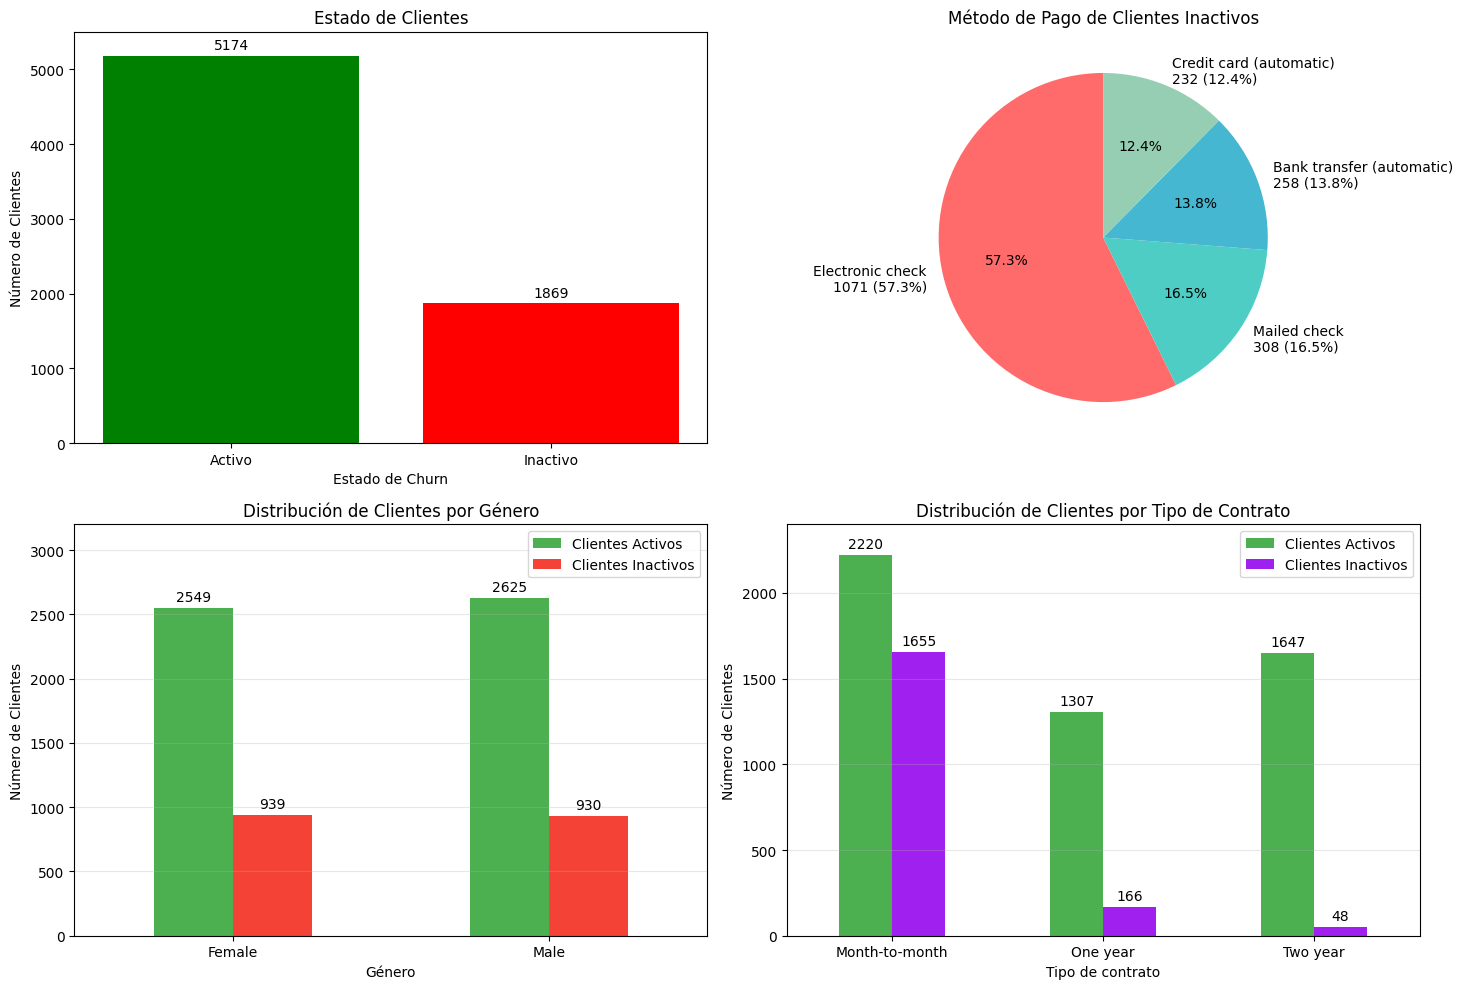

In [215]:
#@title Dashboard

fig, axes = plt.subplots(2,2, figsize=(15, 10))

#Grafico 1
churn_counts = df_limpio['Churn'].value_counts().sort_index()  # ordenar por índice
axes[0,0].bar(['Activo', 'Inactivo'],
               churn_counts.values,
               color=['green', 'red'])
axes[0,0].set_title('Estado de Clientes')
axes[0,0].set_ylabel('Número de Clientes')
axes[0,0].set_ylim(0,5500)
axes[0,0].set_xlabel('Estado de Churn')
# Números encima de las barras
for bar in axes[0,0].patches:
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   str(int(bar.get_height())), ha='center', va='bottom')

# Gráfico 2: MÉTODO DE PAGO DE CLIENTES INACTIVOS (movido a posición 0,1)
clientes_inactivos = df_limpio[df_limpio['Churn'] == 1]
metodo_inactivos = clientes_inactivos['PaymentMethod'].value_counts()

etiquetas = [f'{nombre}\n{valor} ({porcentaje:.1f}%)'
             for nombre, valor, porcentaje in zip(
                 metodo_inactivos.index,
                 metodo_inactivos.values,
                 (metodo_inactivos.values / metodo_inactivos.sum()) * 100)]

axes[0,1].pie(metodo_inactivos.values,
              labels=etiquetas,
              autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
              startangle=90)
axes[0,1].set_title('Método de Pago de Clientes Inactivos')

# Gráfico 3: DISTRIBUCIÓN POR GÉNERO (movido a posición 1,0)
churn_gender = pd.crosstab(df_limpio['gender'], df_limpio['Churn'])
churn_gender.plot(kind='bar',
                  color=['#4CAF50', '#F44336'],
                  ax=axes[1,0])
axes[1,0].set_title('Distribución de Clientes por Género')
axes[1,0].set_xlabel('Género')
axes[1,0].set_ylabel('Número de Clientes')
axes[1,0].set_ylim(0,3200)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=0)
axes[1,0].legend(['Clientes Activos', 'Clientes Inactivos'])
axes[1,0].grid(axis='y', alpha=0.3)
# Números encima de las barras
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, padding=3)

# Gráfico 4: DISTRIBUCIÓN POR CONTRATO (movido a posición 1,1)
churn_contract = pd.crosstab(df_limpio['Contract'], df_limpio['Churn'])
churn_contract.plot(kind='bar',
                    color=['#4CAF50','#A020F0'],
                    ax=axes[1,1])
axes[1,1].set_title('Distribución de Clientes por Tipo de Contrato')
axes[1,1].set_xlabel('Tipo de contrato')
axes[1,1].set_ylabel('Número de Clientes')
axes[1,1].set_ylim(0,2400)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=0)
axes[1,1].legend(['Clientes Activos', 'Clientes Inactivos'])
axes[1,1].grid(axis='y', alpha=0.3)
# Números encima de las barras
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, padding=3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1018600858.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0].boxplot(data_to_plot,


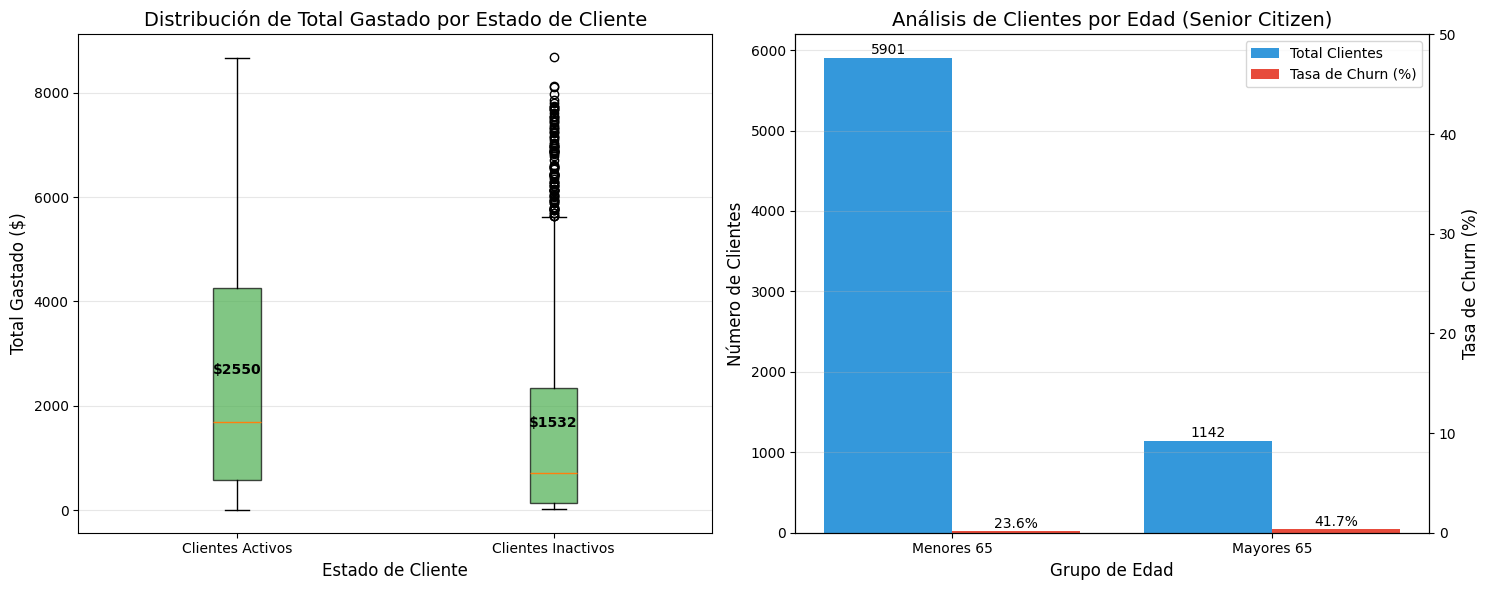

In [227]:
# Crear nueva figura para los dos gráficos analíticos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Distribución de Total Gastado por Churn (Boxplot)
data_to_plot = [
    df_limpio[df_limpio['Churn'] == 0]['Charges.Total'].dropna(),  # Activos
    df_limpio[df_limpio['Churn'] == 1]['Charges.Total'].dropna()   # Inactivos
]

box_plot = axes[0].boxplot(data_to_plot,
               labels=['Clientes Activos', 'Clientes Inactivos'],
               patch_artist=True,
               boxprops=dict(facecolor='#4CAF50', alpha=0.7))

axes[0].set_title('Distribución de Total Gastado por Estado de Cliente', fontsize=14)
axes[0].set_ylabel('Total Gastado ($)', fontsize=12)
axes[0].set_xlabel('Estado de Cliente', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Agregar estadísticas
for i, data in enumerate(data_to_plot):
    mean_val = data.mean()
    axes[0].text(i+1, mean_val, f'${mean_val:.0f}',
                ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Análisis de Clientes Senior Citizen
senior_churn = df_limpio.groupby('SeniorCitizen')['Churn'].agg(['count', 'mean']).reset_index()
senior_churn['churn_rate'] = senior_churn['mean'] * 100

# Crear gráfico de barras agrupadas
x = ['Menores 65', 'Mayores 65']
counts = senior_churn['count']
churn_rates = senior_churn['churn_rate']

# Gráfico de barras dobles
bar1 = axes[1].bar([i - 0.2 for i in range(2)], counts,
                   width=0.4, label='Total Clientes', color='#3498db')
bar2 = axes[1].bar([i + 0.2 for i in range(2)], churn_rates,
                   width=0.4, label='Tasa de Churn (%)', color='#e74c3c')

axes[1].set_title('Análisis de Clientes por Edad (Senior Citizen)', fontsize=14)
axes[1].set_xlabel('Grupo de Edad', fontsize=12)
axes[1].set_ylabel('Número de Clientes', fontsize=12)
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(x)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for i, (count, rate) in enumerate(zip(counts, churn_rates)):
    axes[1].text(i - 0.2, count + 10, str(count), ha='center', va='bottom')
    axes[1].text(i + 0.2, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')

# Eje secundario para la tasa de churn
ax2 = axes[1].twinx()
ax2.set_ylabel('Tasa de Churn (%)', fontsize=12)
ax2.set_ylim(0, 50)

plt.tight_layout()
plt.show()



In [ ]:
# Datos
senior_stats = df_limpio.groupby('SeniorCitizen').agg({
    'Churn': ['count', 'mean'],
    'Charges.Total': 'mean',
    'tenure': 'mean'
}).round(2)

senior_stats.columns = ['Total_Clientes', 'Tasa_Churn', 'Promedio_Gasto', 'Promedio_Tenure']
senior_stats.index = ['Menores_65', 'Mayores_65']

# Gráfico
x = np.arange(len(senior_stats))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para Total de Clientes
rects1 = ax.bar(x - width/2, senior_stats['Total_Clientes'], width, label='Total Clientes', color='#3498db')

# Eje secundario para Tasa de Churn
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, senior_stats['Tasa_Churn'] * 100, width, label='Tasa de Churn (%)', color='#e74c3c')

# Configuración del gráfico
ax.set_title('Análisis de Clientes por Edad (Senior Citizen)', fontsize=14)
ax.set_xlabel('Grupo de Edad', fontsize=12)
ax.set_ylabel('Número de Clientes', fontsize=12)
ax2.set_ylabel('Tasa de Churn (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['Menores 65', 'Mayores 65'])

# Agregar leyendas
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Agregar valores encima de las barras
def autolabel(rects, ax, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.annotate(f'{label:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos arriba de la barra
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax, senior_stats['Total_Clientes'])
autolabel(rects2, ax2, senior_stats['Tasa_Churn'] * 100)

plt.tight_layout()
plt.show()

#📄Informe final

In [ ]:
# Datos
senior_stats = df_limpio.groupby('SeniorCitizen').agg({
    'Churn': ['count', 'mean'],
    'Charges.Total': 'mean',
    'tenure': 'mean'
}).round(2)

senior_stats.columns = ['Total_Clientes', 'Tasa_Churn', 'Promedio_Gasto', 'Promedio_Tenure']
senior_stats.index = ['Menores_65', 'Mayores_65']

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Barras horizontales para Total de Clientes
ax.barh(senior_stats.index, senior_stats['Total_Clientes'],
        color='#3498db', label='Total Clientes')

# Eje secundario para Tasa de Churn
ax2 = ax.twinx()
ax2.barh(senior_stats.index, senior_stats['Tasa_Churn'] * 100,
         color='#e74c3c', label='Tasa de Churn (%)')

# Configuración del gráfico
ax.set_title('Análisis de Clientes por Edad (Senior Citizen)', fontsize=14)
ax.set_xlabel('Número de Clientes', fontsize=12)
ax2.set_xlabel('Tasa de Churn (%)', fontsize=12)
ax.set_yticklabels(['Menores 65', 'Mayores 65'])

# Agregar leyendas
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Agregar valores encima de las barras
def autolabel(rects, ax, labels):
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        ax.annotate(f'{label:.1f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 puntos a la derecha de la barra
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(ax.patches, ax, senior_stats['Total_Clientes'])
autolabel(ax2.patches, ax2, senior_stats['Tasa_Churn'] * 100)

plt.tight_layout()
plt.show()